In [1]:
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from xgboost import XGBClassifier

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, BatchNormalization, Bidirectional
from sklearn.preprocessing import LabelEncoder
import numpy as np
from tensorflow.keras.callbacks import ReduceLROnPlateau


In [3]:
# Download the required resources of nltk
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\c22011387\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\c22011387\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\c22011387\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
df = pd.read_csv('netflix_reviews.csv')

                               reviewId            userName  \
0  5c934dd8-6417-4653-aa21-2d093f468d72      Redwane Stayka   
1  1328c8fe-0596-41c6-9ddf-20a5163a5c50         vivian muir   
2  4ea3b37c-0478-4eb8-9754-7a27f917100c  Madongaolou Edward   
3  7ecc7540-7968-4ba2-be6c-bdf3b0311daf      Stuart Durston   
4  dd57e681-5ae5-4b41-909d-8a868fde751a   Afolayan Damilola   

                                             content  score  thumbsUpCount  \
0  Doesn't allow me to watch with my friend accou...      1              1   
1  i love this app everyone i know uses this app ...      5              0   
2  My phone works fine with other apps but why th...      1              1   
3  Netflix I would have once got a 5 star review....      2              0   
4                                   Good and amazing      5              0   

     reviewCreatedVersion                   at              appVersion  
0  8.114.0 build 19 50680  2024-06-04 21:51:39  8.114.0 build 19 50680  
1   8.

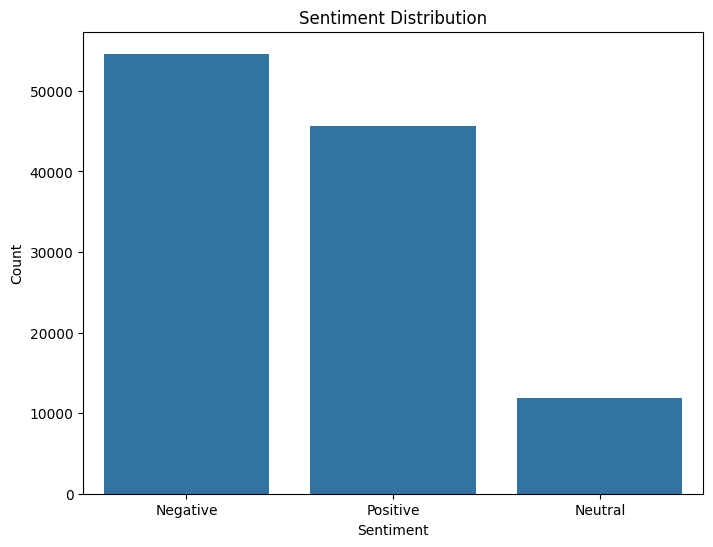


Descriptive statistics of text length:
count    112113.000000
mean        158.328695
std         111.709309
min           1.000000
25%          85.000000
50%         124.000000
75%         196.000000
max        1752.000000
Name: text_length, dtype: float64


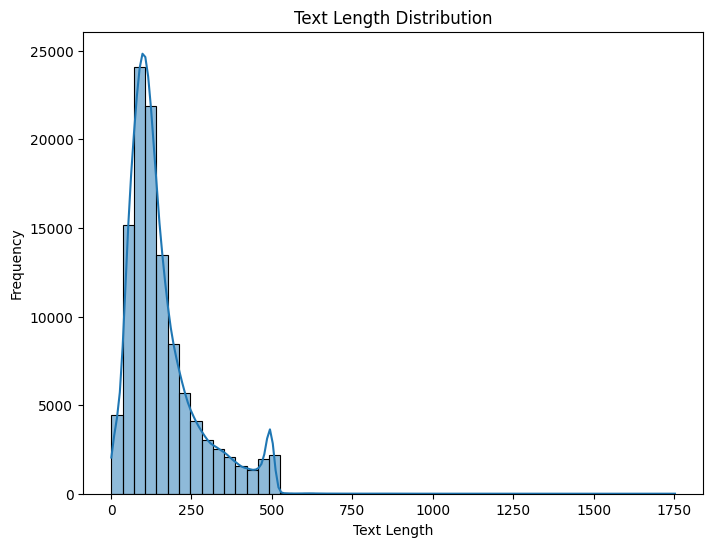

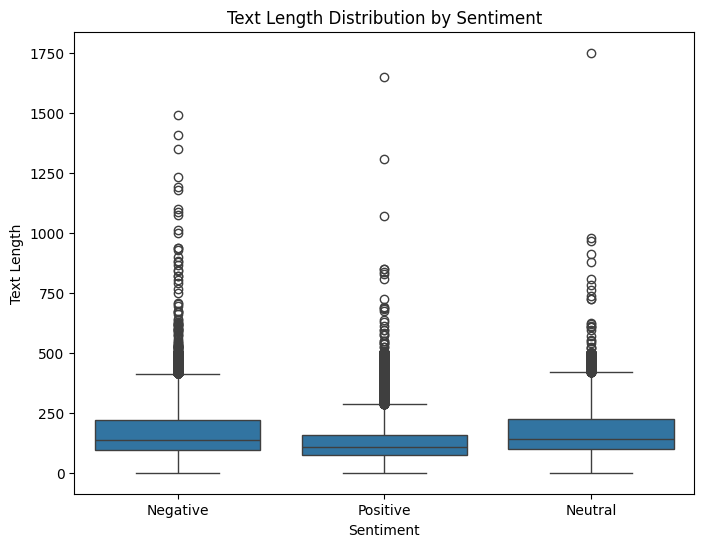

In [5]:
# View data
# View the first few rows of data
print(df.head())
# Check for missing values
print(df.isnull().sum())
# Create a sentiment label column based on the score column 创建情感标签列，基于score列
def label_sentiment(score):
    if score >= 4:
        return 'Positive'
    elif score == 3:
        return 'Neutral'
    else:
        return 'Negative'
df['sentiment'] = df['score'].apply(label_sentiment)

# Check the distribution of sentiment labels 检查情感标签的分布
print("\nDistribution of sentiment labels：")
print(df['sentiment'].value_counts())

# Visualizing the distribution of sentiment labels 可视化情感标签的分布
plt.figure(figsize=(8, 6))
sns.countplot(x='sentiment', data=df)
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

# Analyze text length distribution 分析文本长度分布
df['text_length'] = df['content'].apply(lambda x: len(str(x)))
print("\nDescriptive statistics of text length:")
print(df['text_length'].describe())

# Visualizing text length distribution 可视化文本长度分布
plt.figure(figsize=(8, 6))
sns.histplot(df['text_length'], bins=50, kde=True)
plt.title('Text Length Distribution')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()

# Text length distribution under each sentiment label 各情感标签下的文本长度分布
plt.figure(figsize=(8, 6))
sns.boxplot(x='sentiment', y='text_length', data=df)
plt.title('Text Length Distribution by Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Text Length')
plt.show()

In [6]:
# Data processing
# Remove rows with missing values for `userName` and `content`
df = df.dropna(subset=['userName', 'content'])

# Remove `reviewCreatedVersion` and `appVersion` columns
df = df.drop(columns=['reviewCreatedVersion', 'appVersion'])

# Text cleaning functions
def clean_text(text):
    text = re.sub(r'<.*?>', '', text)  
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = text.lower()  
    return text

# Function to check whether it contains non-English characters
def is_english(text):
    return re.fullmatch(r'[a-zA-Z\s]*', text) is not None

# Functions for word segmentation and stop word removal
def tokenize_and_remove_stopwords(text):
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [word for word in tokens if word.lower() not in stop_words]
    return filtered_tokens

df['cleaned_content'] = df['content'].apply(clean_text)
df = df[df['cleaned_content'].apply(is_english)]
df = df[df['cleaned_content'].str.strip() != '']
df['tokens'] = df['cleaned_content'].apply(tokenize_and_remove_stopwords)

# Convert the `at` column to `datetime` format
df['at'] = pd.to_datetime(df['at'])

# Sort data by date
df = df.sort_values(by='at')

df.to_csv('Sentiment Analysis Model _ TF-IDF.csv', index=False)


In [7]:
# View the cleaned data
print(df.isnull().sum())
print(df.head())
print(df.info())

# View the date range of the `at` column
print("\nTime Scale:")
print("Earliest Date:", df['at'].min())
print("Latest Date:", df['at'].max())

# Statistics by month
monthly_counts = df['at'].dt.to_period('M').value_counts().sort_index()
print("\nVolume of statistics by month:")
print(monthly_counts)

# Statistics by year
yearly_counts = df['at'].dt.to_period('Y').value_counts().sort_index()
print("\nVolume of statistics by year:")
print(yearly_counts)

reviewId           0
userName           0
content            0
score              0
thumbsUpCount      0
at                 0
sentiment          0
text_length        0
cleaned_content    0
tokens             0
dtype: int64
                                   reviewId       userName  \
21675  e940dd6f-b642-44a6-8b2e-48e69d511a8e  A Google user   
55124  b9ca4a19-91ec-4c81-9240-5dd84408a7d7  A Google user   
33555  a9c91494-6787-4584-95d6-80f7c52e1d9a  A Google user   
17928  32e36441-44c3-465d-9161-8a2d617d685b  A Google user   
53961  7aff0740-fd01-4191-9271-f689820740a5  A Google user   

                                                 content  score  \
21675  There are still some fantastic Netflix origina...      4   
55124  Dont really use the app on my phone as much as...      4   
33555  I love Netflix but on my LG v30+ all HDR looks...      3   
17928  Well I downloaded it recently on my new phone ...      1   
53961  Used to work well, now doesn't recognize my pa...      3   

 

In [8]:
# Splitting the dataset
split_date = '2024-01-01' 
train_df = df[df['at'] < split_date]
test_df = df[df['at'] >= split_date]

# Separate text and labels 将文本和标签分开
X_train = train_df['cleaned_content']
y_train = train_df['sentiment']
X_test = test_df['cleaned_content']
y_test = test_df['sentiment']

# Check the size of the split dataset
print("\nTraining set size:", train_df.shape)
print("Test Set Size:", test_df.shape)

# View the amount of data before and after the split point
print("\nVolume of data before split point:", train_df['at'].max())
print("Volume of data after split point:", test_df['at'].min())


Training set size: (95958, 10)
Test Set Size: (16028, 10)

Volume of data before split point: 2023-12-31 20:55:51
Volume of data after split point: 2024-01-01 00:15:11


In [9]:
# Feature extraction: vectorization using TF-IDF 特征提取：使用TF-IDF向量化
tfidf = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

Overall Accuracy: 83.12%

Logistic Regression Model Report:
              precision    recall  f1-score   support

    Negative       0.87      0.91      0.89      9962
     Neutral       0.23      0.04      0.07      1126
    Positive       0.77      0.86      0.81      4940

    accuracy                           0.83     16028
   macro avg       0.63      0.60      0.59     16028
weighted avg       0.80      0.83      0.81     16028



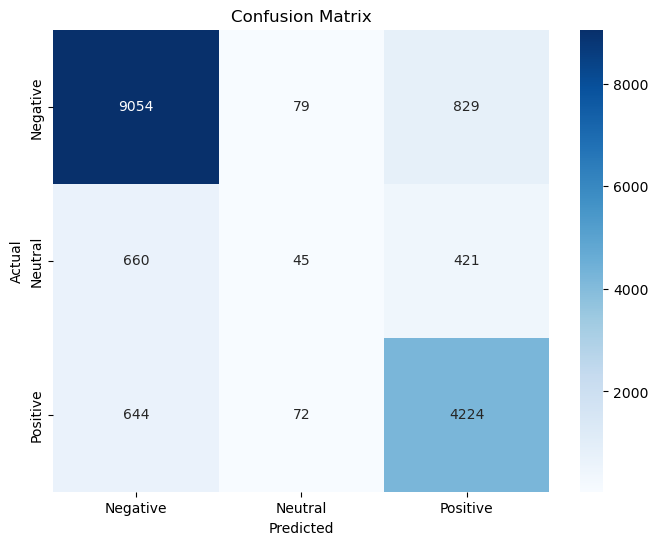

In [9]:
# 1.Logistic regression model
model = LogisticRegression(max_iter=1000)
model.fit(X_train_tfidf, y_train)

# Model predictions
y_pred = model.predict(X_test_tfidf)

# Model Evaluation
print("Overall Accuracy: {:.2f}%".format(accuracy_score(y_test, y_pred) * 100))
print("\nLogistic Regression Model Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

Overall Accuracy: 79.50%

Logistic Regression Model + Class Weight Report1:
              precision    recall  f1-score   support

    Negative       0.89      0.84      0.87      9962
     Neutral       0.21      0.32      0.26      1126
    Positive       0.81      0.81      0.81      4940

    accuracy                           0.79     16028
   macro avg       0.64      0.66      0.64     16028
weighted avg       0.82      0.79      0.81     16028



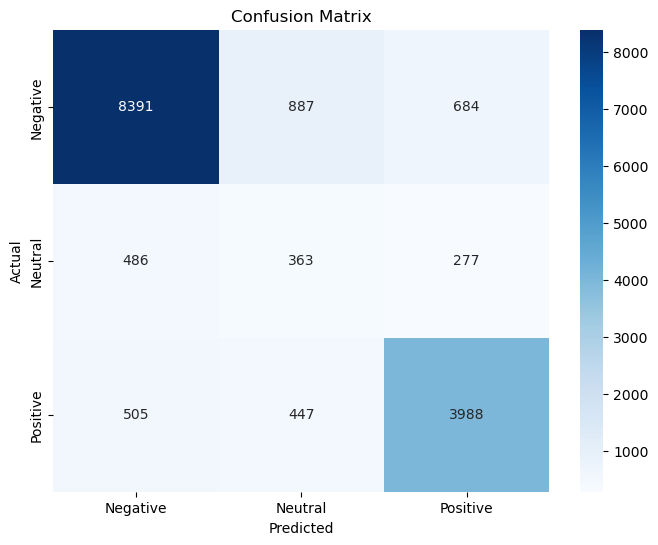

In [10]:
# 2.Adjust class weights to make the model focus more on neutral sentiment 调整类权重，使模型更加关注中性情感
model = LogisticRegression(max_iter=1000, class_weight={'Negative': 1, 'Neutral': 3, 'Positive': 1})
model.fit(X_train_tfidf, y_train)

# Model predictions
y_pred = model.predict(X_test_tfidf)

# Model Evaluation
print("Overall Accuracy: {:.2f}%".format(accuracy_score(y_test, y_pred) * 100))
print("\nLogistic Regression Model + Class Weight Report1:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

Overall Accuracy: 81.73%

Logistic Regression Model + Class Weight Report2:
              precision    recall  f1-score   support

    Negative       0.88      0.88      0.88      9962
     Neutral       0.25      0.20      0.22      1126
    Positive       0.79      0.83      0.81      4940

    accuracy                           0.82     16028
   macro avg       0.64      0.64      0.64     16028
weighted avg       0.81      0.82      0.81     16028



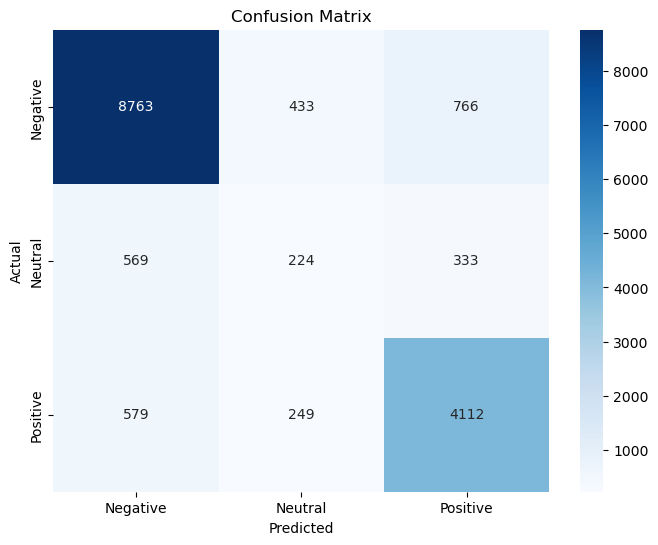

In [11]:
# 3.Adjust class weights to make the model focus more on neutral sentiment 调整类权重，使模型更加关注中性情感
# neutral: 3 -->2
model = LogisticRegression(max_iter=1000, class_weight={'Negative': 1, 'Neutral': 2, 'Positive': 1})
model.fit(X_train_tfidf, y_train)

# Model predictions
y_pred = model.predict(X_test_tfidf)

# Model Evaluation
print("Overall Accuracy: {:.2f}%".format(accuracy_score(y_test, y_pred) * 100))
print("\nLogistic Regression Model + Class Weight Report2:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

Best parameters: {'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}
Overall Accuracy: 81.57%

Logistic Regression Model + GridSearchCV Report:
              precision    recall  f1-score   support

    Negative       0.89      0.88      0.88      9962
     Neutral       0.24      0.21      0.22      1126
    Positive       0.79      0.83      0.81      4940

    accuracy                           0.82     16028
   macro avg       0.64      0.64      0.64     16028
weighted avg       0.81      0.82      0.81     16028



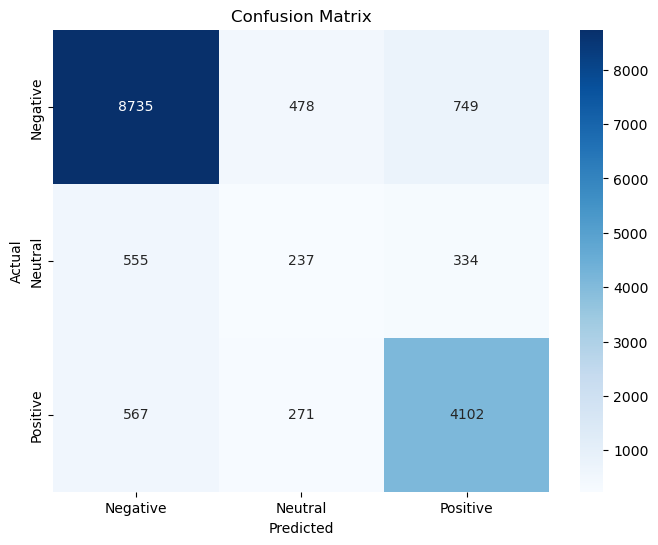

In [12]:
# 4.Hyperparameter Tuning (Grid Search)
# 超参数调优（网格搜索） 使用网格搜索来优化逻辑回归的正则化参数。

# Defining the parameter grid
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']  # 'liblinear' supports both l1 and l2 penalties
}

# Instantiating the Logistic Regression Model
model = LogisticRegression(max_iter=1000, class_weight='balanced')

# Grid Search
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='f1_weighted')
grid_search.fit(X_train_tfidf, y_train)

# Output the best parameters
print("Best parameters:", grid_search.best_params_)

# Train the model using the best parameters
best_model = grid_search.best_estimator_

# Model predictions
y_pred = best_model.predict(X_test_tfidf)

# Model Evaluation
print("Overall Accuracy: {:.2f}%".format(accuracy_score(y_test, y_pred) * 100))
print("\nLogistic Regression Model + GridSearchCV Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=best_model.classes_, yticklabels=best_model.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

Overall Accuracy: 77.20%

Logistic regression model + Feature extraction optimization report:
              precision    recall  f1-score   support

    Negative       0.90      0.80      0.85      9962
     Neutral       0.20      0.42      0.27      1126
    Positive       0.82      0.79      0.80      4940

    accuracy                           0.77     16028
   macro avg       0.64      0.67      0.64     16028
weighted avg       0.83      0.77      0.79     16028



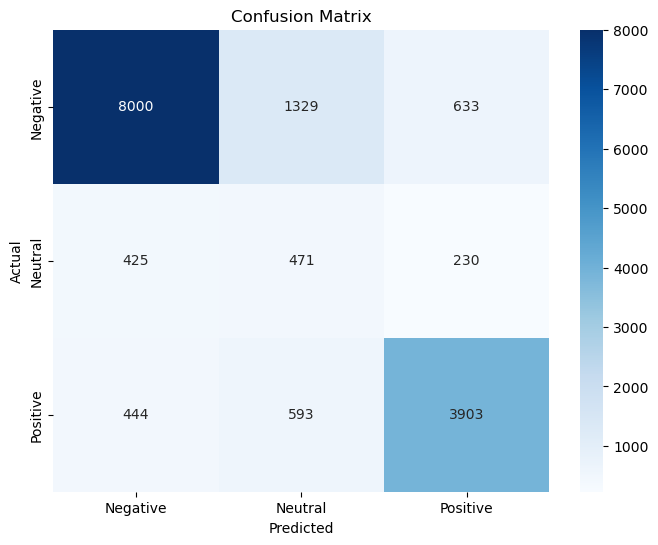

In [17]:
# 5.Feature extraction optimization 特征提取优化
# Avoid affecting the original dataset
X_train2 = train_df['cleaned_content']
y_train2 = train_df['sentiment']
X_test2 = test_df['cleaned_content']
y_test2 = test_df['sentiment']

# Feature extraction: Use TF-IDF vectorization to extract single and double word features
tfidf = TfidfVectorizer(ngram_range=(1, 2), max_features=5000)
X_train_tfidf = tfidf.fit_transform(X_train2)  
X_test_tfidf = tfidf.transform(X_test2) 

# Logistic regression model
model = LogisticRegression(max_iter=1000, class_weight='balanced')
model.fit(X_train_tfidf, y_train2) 

# Model prediction
y_pred = model.predict(X_test_tfidf)

# Model evaluation
print("Overall Accuracy: {:.2f}%".format(accuracy_score(y_test2, y_pred) * 100))  # <-- 修改为 y_test2
print("\nLogistic regression model + Feature extraction optimization report:")
print(classification_report(y_test2, y_pred)) 

# Confusion Matrix
conf_matrix = confusion_matrix(y_test2, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

Overall Accuracy: 76.92%

Logistic regression model + Feature extraction optimization report2:
              precision    recall  f1-score   support

    Negative       0.90      0.80      0.85      9962
     Neutral       0.19      0.41      0.26      1126
    Positive       0.81      0.79      0.80      4940

    accuracy                           0.77     16028
   macro avg       0.64      0.67      0.64     16028
weighted avg       0.83      0.77      0.79     16028



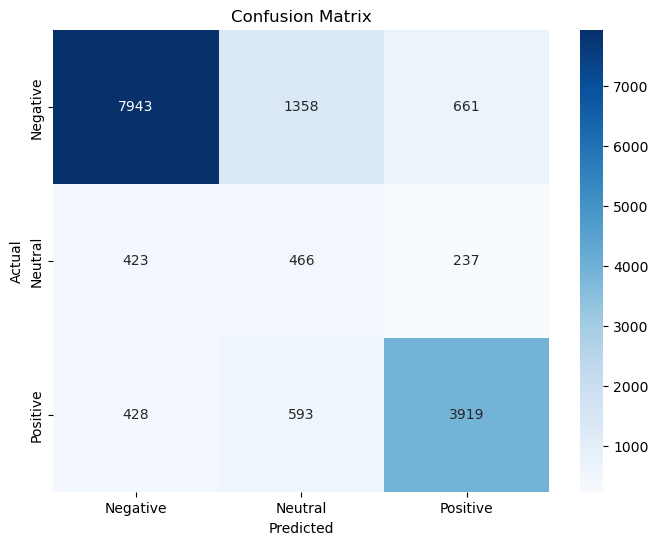

In [18]:
# 6.Feature extraction optimization2 --> ngram_range=(1, 3)    特征提取优化2
# Use TF-IDF vectorization to extract single, double and triple word features使用TF-IDF向量化，提取单词、双词和三词特征
tfidf = TfidfVectorizer(ngram_range=(1, 3), max_features=5000)
X_train_tfidf = tfidf.fit_transform(X_train2)  
X_test_tfidf = tfidf.transform(X_test2) 

# Logistic regression model
model = LogisticRegression(max_iter=1000, class_weight='balanced')
model.fit(X_train_tfidf, y_train2) 

# Model prediction
y_pred = model.predict(X_test_tfidf)

# Model evaluation
print("Overall Accuracy: {:.2f}%".format(accuracy_score(y_test2, y_pred) * 100))  # <-- 修改为 y_test2
print("\nLogistic regression model + Feature extraction optimization report2:")
print(classification_report(y_test2, y_pred)) 

# Confusion Matrix
conf_matrix = confusion_matrix(y_test2, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
# Logistic regression code summary:
# 1.Logistic regression model
model = LogisticRegression(max_iter=1000)
model.fit(X_train_tfidf, y_train)
y_pred = model.predict(X_test_tfidf)


# 2.Adjust class weights to make the model focus more on neutral sentiment 调整类权重，使模型更加关注中性情感
model = LogisticRegression(max_iter=1000, class_weight={'Negative': 1, 'Neutral': 3, 'Positive': 1})
model.fit(X_train_tfidf, y_train)
y_pred = model.predict(X_test_tfidf)


# 3.Adjust class weights to make the model focus more on neutral sentiment 调整类权重，使模型更加关注中性情感
# neutral: 3 -->2
model = LogisticRegression(max_iter=1000, class_weight={'Negative': 1, 'Neutral': 2, 'Positive': 1})
model.fit(X_train_tfidf, y_train)
y_pred = model.predict(X_test_tfidf)


# 4.Hyperparameter Tuning (Grid Search)
# 超参数调优（网格搜索） 使用网格搜索来优化逻辑回归的正则化参数。

# Defining the parameter grid
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']
}

# Instantiating the Logistic Regression Model
model = LogisticRegression(max_iter=1000, class_weight='balanced')

# Grid Search
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='f1_weighted')
grid_search.fit(X_train_tfidf, y_train)

# Output the best parameters
print("Best parameters:", grid_search.best_params_)

# Train the model using the best parameters
best_model = grid_search.best_estimator_
y_pred = model.predict(X_test_tfidf)


# 5.Feature extraction optimization 特征提取优化
# Avoid affecting the original dataset
X_train2 = train_df['cleaned_content']
y_train2 = train_df['sentiment']
X_test2 = test_df['cleaned_content']
y_test2 = test_df['sentiment']

# Feature extraction: Use TF-IDF vectorization to extract single and double word features
tfidf = TfidfVectorizer(ngram_range=(1, 2), max_features=5000)
X_train_tfidf = tfidf.fit_transform(X_train2)  
X_test_tfidf = tfidf.transform(X_test2) 

# Logistic regression model
model = LogisticRegression(max_iter=1000, class_weight='balanced')
model.fit(X_train_tfidf, y_train2) 
y_pred = model.predict(X_test_tfidf

# 6.Feature extraction optimization2 --> ngram_range=(1, 3)    特征提取优化2
# Use TF-IDF vectorization to extract single, double and triple word features使用TF-IDF向量化，提取单词、双词和三词特征
tfidf = TfidfVectorizer(ngram_range=(1, 3), max_features=5000)
X_train_tfidf = tfidf.fit_transform(X_train2)  
X_test_tfidf = tfidf.transform(X_test2) 

# Logistic regression model
model = LogisticRegression(max_iter=1000, class_weight='balanced')
model.fit(X_train_tfidf, y_train2) 
y_pred = model.predict(X_test_tfidf)
                       
                       
# Model Evaluation
print("Overall Accuracy: {:.2f}%".format(accuracy_score(y_test, y_pred) * 100))
print("\nLogistic Regression Model + Class Weight Report1:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

Overall Accuracy: 81.30%

Ensemble Learning report(Logistic regression, Random forests and Gradient boosting):
              precision    recall  f1-score   support

    Negative       0.83      0.93      0.88      9962
     Neutral       0.28      0.04      0.07      1126
    Positive       0.78      0.76      0.77      4940

    accuracy                           0.81     16028
   macro avg       0.63      0.57      0.57     16028
weighted avg       0.78      0.81      0.79     16028



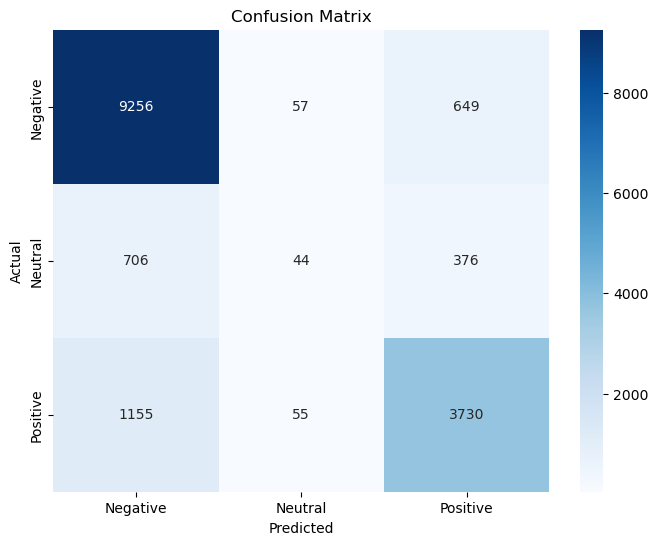

In [15]:
# 1.Ensemble Learning  集成学习
# Defining the Model
lr_model = LogisticRegression(max_iter=1000, class_weight='balanced')
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
gb_model = GradientBoostingClassifier(n_estimators=100, random_state=42)

# Model Ensemble Using Voting 使用投票法进行模型集成
voting_clf = VotingClassifier(estimators=[('lr', lr_model), ('rf', rf_model), ('gb', gb_model)], voting='soft')
voting_clf.fit(X_train_tfidf, y_train)

# Model predictions
y_pred = voting_clf.predict(X_test_tfidf)

# Model Evaluation
print("Overall Accuracy: {:.2f}%".format(accuracy_score(y_test, y_pred) * 100))
print("\nEnsemble Learning report(Logistic regression, Random forests and Gradient boosting):")
print(classification_report(y_test, y_pred))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=voting_clf.classes_, yticklabels=voting_clf.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


C:\Users\c22011387\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:158: UserWarning: [20:38:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Overall Accuracy: 80.96%

Ensemble Learning report2(Random forests, Gradient boosting and XGBoost):
              precision    recall  f1-score   support

    Negative       0.83      0.93      0.88      9962
     Neutral       0.25      0.02      0.04      1126
    Positive       0.78      0.75      0.76      4940

    accuracy                           0.81     16028
   macro avg       0.62      0.57      0.56     16028
weighted avg       0.77      0.81      0.78     16028



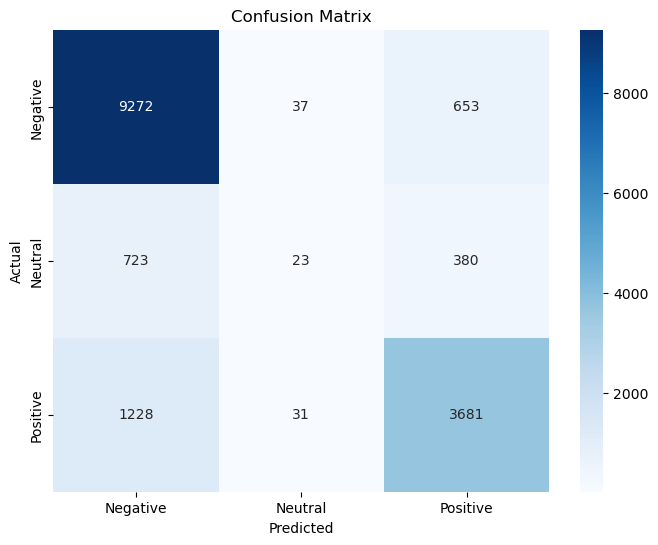

In [16]:
# 2.More ensemble learning
# Defining more models
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
gb_model = GradientBoostingClassifier(n_estimators=100, random_state=42)
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')

# Model Ensemble Using Voting
voting_clf = VotingClassifier(estimators=[('lr', lr_model), ('rf', rf_model), ('gb', gb_model), ('xgb', xgb_model)], voting='soft')
voting_clf.fit(X_train_tfidf, y_train)

# Model predictions
y_pred = voting_clf.predict(X_test_tfidf)

# Model Evaluation
print("Overall Accuracy: {:.2f}%".format(accuracy_score(y_test, y_pred) * 100))
print("\nEnsemble Learning report2(Random forests, Gradient boosting and XGBoost):")
print(classification_report(y_test, y_pred))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=voting_clf.classes_, yticklabels=voting_clf.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [10]:
# Prepare data for LSTM model
X_train = train_df['cleaned_content']
X_test = test_df['cleaned_content']

# Convert sentiment labels to numerical encoding
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(train_df['sentiment'])
y_test = label_encoder.transform(test_df['sentiment'])

# Create Tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
vocab_size = len(tokenizer.word_index) + 1

# Convert texts to sequences
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Pad sequences
max_len = 100  # Choose appropriate sequence length
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len)

Epoch 1/5
2699/2699 ━━━━━━━━━━━━━━━━━━━━ 338s 122ms/step - accuracy: 0.7436 - loss: 0.6638 - val_accuracy: 0.8118 - val_loss: 0.5446
Epoch 2/5
2699/2699 ━━━━━━━━━━━━━━━━━━━━ 341s 126ms/step - accuracy: 0.8025 - loss: 0.5141 - val_accuracy: 0.8212 - val_loss: 0.5108
Epoch 3/5
2699/2699 ━━━━━━━━━━━━━━━━━━━━ 344s 112ms/step - accuracy: 0.8232 - loss: 0.4585 - val_accuracy: 0.7941 - val_loss: 0.5574
Epoch 4/5
2699/2699 ━━━━━━━━━━━━━━━━━━━━ 307s 114ms/step - accuracy: 0.8469 - loss: 0.4053 - val_accuracy: 0.7985 - val_loss: 0.5729
Epoch 5/5
2699/2699 ━━━━━━━━━━━━━━━━━━━━ 296s 110ms/step - accuracy: 0.8700 - loss: 0.3442 - val_accuracy: 0.7918 - val_loss: 0.6458
501/501 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step
Overall Accuracy: 79.83%
LSTM Model Report:
              precision    recall  f1-score   support

    Negative       0.88      0.87      0.87      9962
     Neutral       0.18      0.13      0.15      1126
    Positive       0.75      0.82      0.78      4940

    accuracy                  

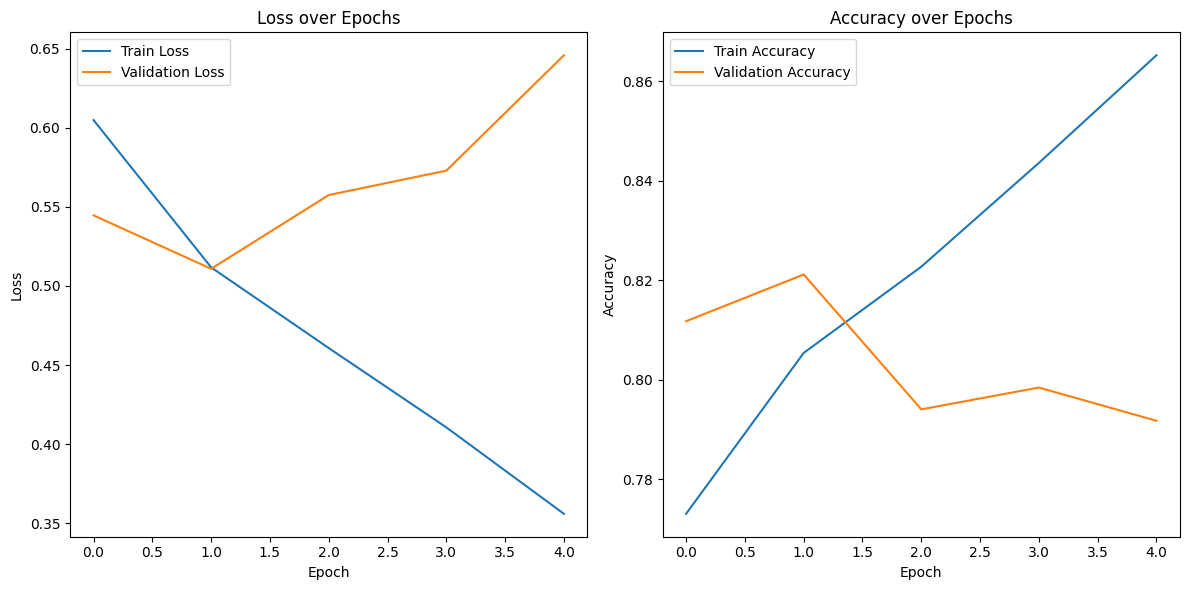

In [11]:
# 1.LSTM model
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=128))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(len(label_encoder.classes_), activation='softmax'))  # Number of classes

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train_pad, y_train, epochs=5, batch_size=32, validation_split=0.1, verbose=1)

# Evaluate the model
y_pred_prob = model.predict(X_test_pad)
y_pred_classes = np.argmax(y_pred_prob, axis=-1)

# Print model evaluation report
print("Overall Accuracy: {:.2f}%".format(accuracy_score(y_test, y_pred_classes) * 100))
print("LSTM Model Report:")
print(classification_report(y_test, y_pred_classes, target_names=label_encoder.classes_))

# Plot training process
plt.figure(figsize=(12, 6))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

Epoch 1/5
2699/2699 ━━━━━━━━━━━━━━━━━━━━ 375s 138ms/step - accuracy: 0.7151 - loss: 0.7146 - val_accuracy: 0.8195 - val_loss: 0.5289
Epoch 2/5
2699/2699 ━━━━━━━━━━━━━━━━━━━━ 387s 143ms/step - accuracy: 0.8018 - loss: 0.5449 - val_accuracy: 0.8248 - val_loss: 0.4940
Epoch 3/5
2699/2699 ━━━━━━━━━━━━━━━━━━━━ 395s 146ms/step - accuracy: 0.8109 - loss: 0.5036 - val_accuracy: 0.8256 - val_loss: 0.5212
Epoch 4/5
2699/2699 ━━━━━━━━━━━━━━━━━━━━ 388s 144ms/step - accuracy: 0.8181 - loss: 0.4769 - val_accuracy: 0.8238 - val_loss: 0.5314
Epoch 5/5
2699/2699 ━━━━━━━━━━━━━━━━━━━━ 408s 151ms/step - accuracy: 0.8257 - loss: 0.4436 - val_accuracy: 0.8217 - val_loss: 0.5362
501/501 ━━━━━━━━━━━━━━━━━━━━ 20s 40ms/step
Overall Accuracy:  82.52%
LSTM Model + Dropout Report:
              precision    recall  f1-score   support

    Negative       0.85      0.92      0.88      9962
     Neutral       0.30      0.02      0.05      1126
    Positive       0.78      0.81      0.80      4940

    accuracy       

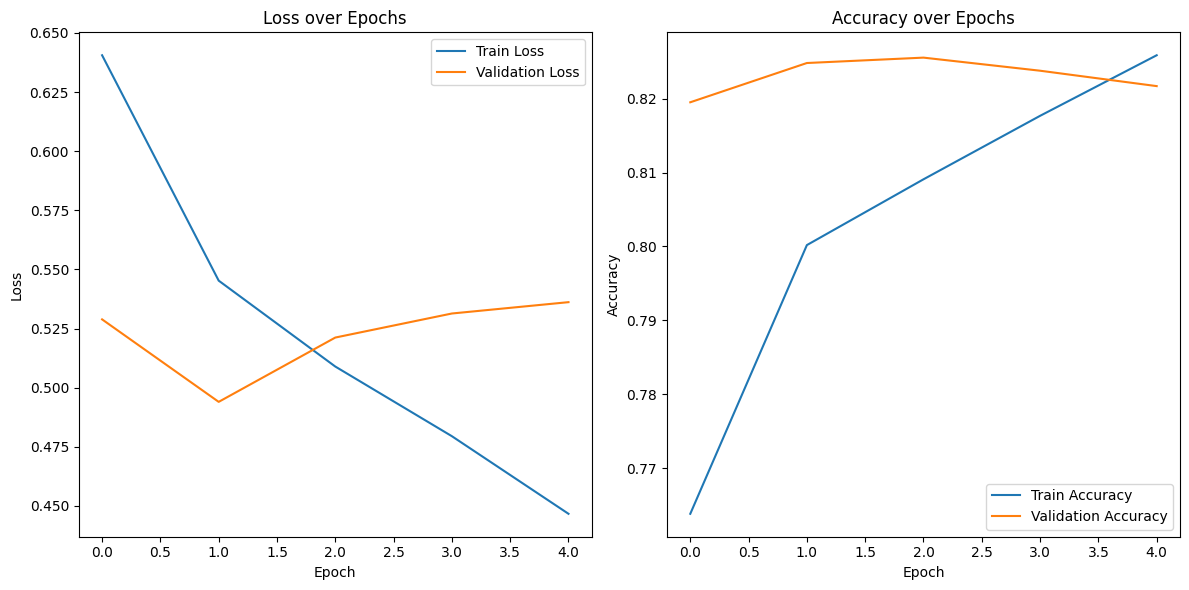

In [14]:
# 2.LSTM model with Dropout
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=128, input_length=max_len))
model.add(LSTM(128, dropout=0.3, recurrent_dropout=0.3, return_sequences=True))
model.add(LSTM(64, dropout=0.3, recurrent_dropout=0.3))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train_pad, y_train, epochs=5, batch_size=32, validation_split=0.1, verbose=1)

# Evaluate the model
y_pred_prob = model.predict(X_test_pad)
y_pred_classes = y_pred_prob.argmax(axis=-1)

# Print model evaluation report
print("Overall Accuracy:  {:.2f}%".format(accuracy_score(y_test, y_pred_classes) * 100))
print("LSTM Model + Dropout Report:")
print(classification_report(y_test, y_pred_classes, target_names=label_encoder.classes_))

# Plot training accuracy and loss
plt.figure(figsize=(12, 6))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

Epoch 1/5


C:\Users\c22011387\OneDrive - Cardiff University\Desktop\Data-analysis\myenv\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


2699/2699 ━━━━━━━━━━━━━━━━━━━━ 450s 165ms/step - accuracy: 0.5980 - loss: 0.9278 - val_accuracy: 0.8193 - val_loss: 0.5592
Epoch 2/5
2699/2699 ━━━━━━━━━━━━━━━━━━━━ 455s 169ms/step - accuracy: 0.7923 - loss: 0.5767 - val_accuracy: 0.8185 - val_loss: 0.5268
Epoch 3/5
2699/2699 ━━━━━━━━━━━━━━━━━━━━ 405s 150ms/step - accuracy: 0.8039 - loss: 0.5349 - val_accuracy: 0.8220 - val_loss: 0.5381
Epoch 4/5
2699/2699 ━━━━━━━━━━━━━━━━━━━━ 387s 143ms/step - accuracy: 0.8071 - loss: 0.5216 - val_accuracy: 0.8160 - val_loss: 0.5463
Epoch 5/5
2699/2699 ━━━━━━━━━━━━━━━━━━━━ 397s 147ms/step - accuracy: 0.8188 - loss: 0.4820 - val_accuracy: 0.8184 - val_loss: 0.5512
501/501 ━━━━━━━━━━━━━━━━━━━━ 22s 43ms/step
Overall Accuracy:  81.85%
LSTM Model + Dropout and BatchNormalization Report:
              precision    recall  f1-score   support

    Negative       0.86      0.90      0.88      9962
     Neutral       0.50      0.00      0.01      1126
    Positive       0.75      0.83      0.79      4940

    ac

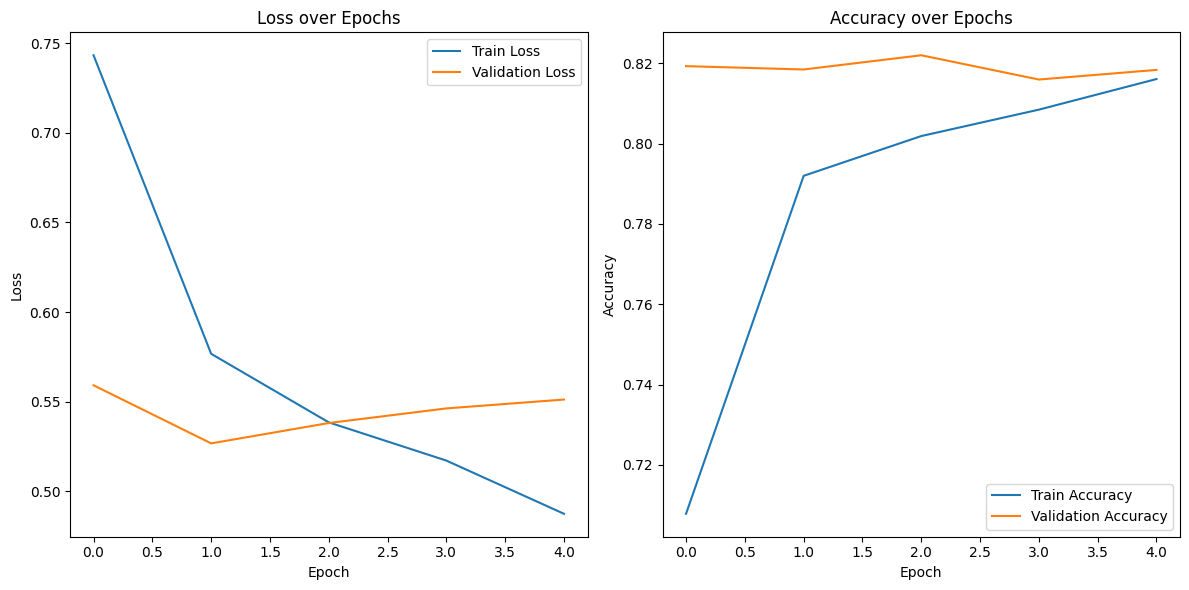

In [15]:
# 3. LSTM model with Dropout and BatchNormalization
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=128, input_length=max_len))
model.add(LSTM(128, dropout=0.3, recurrent_dropout=0.3, return_sequences=True))
model.add(BatchNormalization())
model.add(LSTM(64, dropout=0.3, recurrent_dropout=0.3))
model.add(BatchNormalization())
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train_pad, y_train, epochs=5, batch_size=32, validation_split=0.1, verbose=1)

# Evaluate the model
y_pred_prob = model.predict(X_test_pad)
y_pred_classes = y_pred_prob.argmax(axis=-1)

# Print model evaluation report
print("Overall Accuracy:  {:.2f}%".format(accuracy_score(y_test, y_pred_classes) * 100))
print("LSTM Model + Dropout and BatchNormalization Report:")
print(classification_report(y_test, y_pred_classes, target_names=label_encoder.classes_))

# Plot training accuracy and loss
plt.figure(figsize=(12, 6))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

Epoch 1/10


C:\Users\c22011387\OneDrive - Cardiff University\Desktop\Data-analysis\myenv\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


2699/2699 ━━━━━━━━━━━━━━━━━━━━ 489s 179ms/step - accuracy: 0.7024 - loss: 1.0605 - val_accuracy: 0.7550 - val_loss: 0.6514 - learning_rate: 0.0010
Epoch 2/10
2699/2699 ━━━━━━━━━━━━━━━━━━━━ 465s 172ms/step - accuracy: 0.7525 - loss: 0.8577 - val_accuracy: 0.7740 - val_loss: 0.5876 - learning_rate: 0.0010
Epoch 3/10
2699/2699 ━━━━━━━━━━━━━━━━━━━━ 469s 174ms/step - accuracy: 0.7662 - loss: 0.8001 - val_accuracy: 0.7406 - val_loss: 0.6390 - learning_rate: 0.0010
Epoch 4/10
2699/2699 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - accuracy: 0.7830 - loss: 0.7362
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
2699/2699 ━━━━━━━━━━━━━━━━━━━━ 455s 169ms/step - accuracy: 0.7830 - loss: 0.7362 - val_accuracy: 0.7087 - val_loss: 0.6589 - learning_rate: 0.0010
Epoch 5/10
2699/2699 ━━━━━━━━━━━━━━━━━━━━ 450s 167ms/step - accuracy: 0.8125 - loss: 0.6548 - val_accuracy: 0.7342 - val_loss: 0.6736 - learning_rate: 5.0000e-04
Epoch 6/10
2699/2699 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - accu

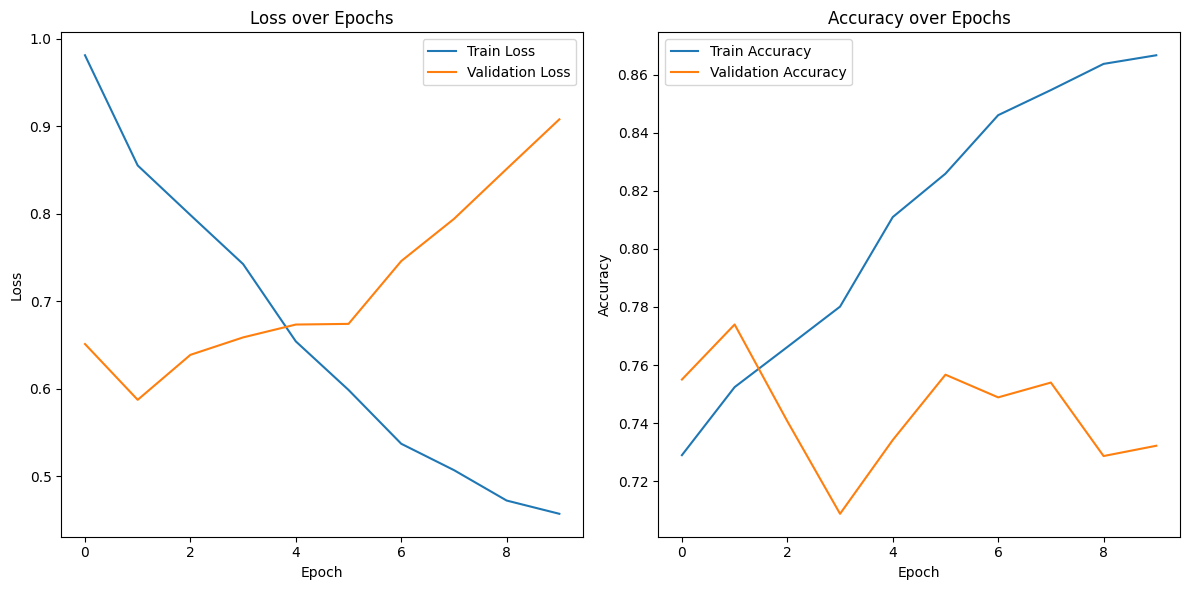

In [16]:
# 4. Bidirectional LSTM model with class weights  具有类别权重的双向 LSTM 模型
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=128, input_length=max_len))
model.add(Bidirectional(LSTM(128, dropout=0.3, recurrent_dropout=0.3, return_sequences=True)))
model.add(LSTM(64, dropout=0.3, recurrent_dropout=0.3))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Set class weights
class_weights = {
    0: 1.0,   # Negative
    1: 3.0,   # Neutral
    2: 1.0,   # Positive
}

# Learning rate scheduling
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1)

# Train the model
history = model.fit(
    X_train_pad, y_train,
    epochs=10, 
    batch_size=32,
    validation_split=0.1,
    class_weight=class_weights,
    callbacks=[lr_scheduler],
    verbose=1
)

# Evaluate the model
y_pred_prob = model.predict(X_test_pad)
y_pred_classes = y_pred_prob.argmax(axis=-1)

# Print model evaluation report
print("Overall Accuracy:  {:.2f}%".format(accuracy_score(y_test, y_pred_classes) * 100))
print("Bidirectional LSTM model + Class weights Report:")
print(classification_report(y_test, y_pred_classes, target_names=label_encoder.classes_))

# Plot training accuracy and loss
plt.figure(figsize=(12, 6))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
#  LSTM Summary
# 1.LSTM model
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=128))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(len(label_encoder.classes_), activation='softmax'))  # Number of classes
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_train_pad, y_train, epochs=5, batch_size=32, validation_split=0.1, verbose=1)

# 2.LSTM model with Dropout
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=128, input_length=max_len))
model.add(LSTM(128, dropout=0.3, recurrent_dropout=0.3, return_sequences=True))
model.add(LSTM(64, dropout=0.3, recurrent_dropout=0.3))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_train_pad, y_train, epochs=5, batch_size=32, validation_split=0.1, verbose=1)

# 3. LSTM model with Dropout and BatchNormalization
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=128, input_length=max_len))
model.add(LSTM(128, dropout=0.3, recurrent_dropout=0.3, return_sequences=True))
model.add(BatchNormalization())
model.add(LSTM(64, dropout=0.3, recurrent_dropout=0.3))
model.add(BatchNormalization())
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_train_pad, y_train, epochs=5, batch_size=32, validation_split=0.1, verbose=1)

# 4. Bidirectional LSTM model with class weights  具有类别权重的双向 LSTM 模型
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=128, input_length=max_len))
model.add(Bidirectional(LSTM(128, dropout=0.3, recurrent_dropout=0.3, return_sequences=True)))
model.add(LSTM(64, dropout=0.3, recurrent_dropout=0.3))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
# Set class weights
class_weights = {
    0: 1.0,   # Negative
    1: 3.0,   # Neutral
    2: 1.0,   # Positive
}
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1)
history = model.fit(
    X_train_pad, y_train,
    epochs=10, 
    batch_size=32,
    validation_split=0.1,
    class_weight=class_weights,
    callbacks=[lr_scheduler],
    verbose=1
)

y_pred_prob = model.predict(X_test_pad)
y_pred_classes = y_pred_prob.argmax(axis=-1)
print("Overall Accuracy:  {:.2f}%".format(accuracy_score(y_test, y_pred_classes) * 100))
print("Bidirectional LSTM model + Class weights Report:")
print(classification_report(y_test, y_pred_classes, target_names=label_encoder.classes_))
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()
plt.tight_layout()
plt.show()